In [2]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import tensorflow as tf
from torchvision import transforms
from PIL import Image

In [37]:
import numpy as np
import pandas as pd

# Load the data from CSV
data = pd.read_csv('../Dataset/climate_dataset/train_data.csv')

data_no_duplicates = data.drop_duplicates(subset=['Lat', 'Lon'])
grid = data_no_duplicates.pivot(index='Lat', columns='Lon', values='Value')

# Convert the grid to a NumPy array
tensor = grid.to_numpy()

# Now, tensor is a 2D array where rows represent latitudes, columns represent longitudes,
# and the values are the corresponding climate data.

print(tensor.shape)
print(tensor.size)
print("Tensor data type:", tensor.dtype)


(360, 720)
259200
Tensor data type: float64


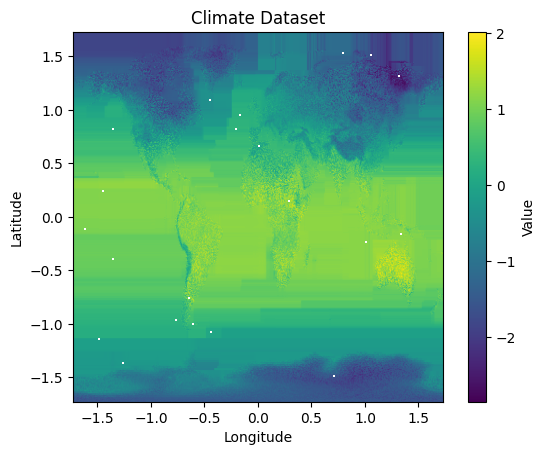

In [39]:
import matplotlib.pyplot as plt

# Assuming 'tensor' is your 2D array
plt.imshow(tensor, origin='lower', extent=[data['Lon'].min(), data['Lon'].max(), data['Lat'].min(), data['Lat'].max()])
plt.colorbar(label='Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Climate Dataset')
plt.show()



In [50]:
# Patch Partition
from swin_functions_and_classes import PatchEmbed

# Assuming 'tensor' is your 2D array
tensor_image = torch.from_numpy(tensor).unsqueeze(0).unsqueeze(0).float()  # Convert to PyTorch tensor and add batch/channel dimensions

# Initialize the PatchEmbed module
patch_embed = PatchEmbed(img_size=(360,720), patch_size=3, in_chans=1, embed_dim=9)

# Apply the PatchEmbed module to the tensor
embedding = patch_embed(tensor_image)
patches = patch_embed(tensor_image)

# Print the shape of the output patches
print("Embedding shape:", patches.shape)

embedding



Embedding shape: torch.Size([1, 28800, 9])


tensor([[[-1.6377, -1.2107,  0.4645,  ..., -0.1224,  0.1294,  0.2742],
         [-1.7123, -1.2151,  0.5069,  ..., -0.1517,  0.1048,  0.2368],
         [-1.7247, -1.3728,  0.3401,  ..., -0.1653,  0.0980,  0.2024],
         ...,
         [-1.6243, -1.1973,  0.4776,  ..., -0.1193,  0.1431,  0.2957],
         [-1.5992, -1.1870,  0.4674,  ..., -0.1163,  0.1205,  0.2775],
         [-1.6263, -1.2119,  0.4787,  ..., -0.1244,  0.1049,  0.2801]]],
       grad_fn=<TransposeBackward0>)

In [48]:
print("First patch embedding vector:", patches[0, 0])

First patch embedding vector: tensor([ 0.0884, -1.1550,  1.1538,  0.3602, -0.5116,  0.3952, -0.3167,  0.5779,
         0.1261], grad_fn=<SelectBackward0>)


In [79]:
from swin_functions_and_classes import *


stage_1 = BasicLayer(dim=9, input_resolution=(120, 240), depth=2, num_heads=3, window_size=6)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output


torch.Size([1, 28800, 9])


tensor([[[-2.5067, -1.2747, -0.9476,  ..., -0.7272,  0.3063,  1.4629],
         [-2.5874, -1.2766, -0.9009,  ..., -0.7571,  0.2714,  1.4380],
         [-2.6083, -1.4147, -1.0871,  ..., -0.7469,  0.2711,  1.3426],
         ...,
         [-2.4473, -1.3024, -0.9361,  ..., -0.7064,  0.3421,  1.4181],
         [-2.4260, -1.2908, -0.9452,  ..., -0.6989,  0.3163,  1.3965],
         [-2.4575, -1.3136, -0.9332,  ..., -0.7050,  0.2986,  1.3988]]],
       grad_fn=<AddBackward0>)

In [80]:
# Swin Transformer Block

# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=9, input_resolution=(120, 240), num_heads=3, window_size=6, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=9, input_resolution=(120, 240), num_heads=3, window_size=6, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)


torch.Size([1, 28800, 9])
torch.Size([1, 28800, 9])
tensor([[[-1.4654, -1.5957,  0.2226,  ..., -0.1608,  0.0584, -0.3638],
         [-1.5264, -1.6029,  0.2648,  ..., -0.1855,  0.0309, -0.3849],
         [-1.5743, -1.7513,  0.1112,  ..., -0.2203,  0.0305, -0.4597],
         ...,
         [-1.4260, -1.6102,  0.1886,  ..., -0.1803,  0.1114, -0.3432],
         [-1.4013, -1.5966,  0.1833,  ..., -0.1810,  0.0894, -0.3640],
         [-1.4259, -1.6210,  0.1949,  ..., -0.1902,  0.0733, -0.3588]]],
       grad_fn=<AddBackward0>)
tensor([[[-1.6256, -1.7234,  1.0674,  ..., -0.5198, -0.2356,  0.3320],
         [-1.6946, -1.7378,  1.1174,  ..., -0.5388, -0.2538,  0.2968],
         [-1.7307, -1.8326,  0.9200,  ..., -0.5874, -0.2881,  0.2572],
         ...,
         [-1.6135, -1.7156,  1.0864,  ..., -0.5339, -0.2124,  0.3530],
         [-1.5909, -1.6979,  1.0728,  ..., -0.5342, -0.2385,  0.3365],
         [-1.6187, -1.7220,  1.0846,  ..., -0.5425, -0.2551,  0.3402]]],
       grad_fn=<AddBackward0>)


In [85]:
# PatchMerging

# USing patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(120, 240), dim=9, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 60x120, 9*2) # (1, 784, 18)

Merged output shape: torch.Size([1, 7200, 18])
